In [1]:
import os
import qiime2 as q2
import pandas as pd
import numpy as np
from biom.util import biom_open
from subprocess import check_call
from scipy.spatial import distance
from biom import load_table, Table
from skbio import OrdinationResults
from assets.step_wise_anova import run_stepwise_anova
from skbio.stats.distance import permanova, anosim
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.diversity.actions import beta_group_significance

# stats tests
from scipy.linalg import norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import wilcoxon, ttest_ind, f_oneway, ttest_rel
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.stats.multitest import multipletests

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

# warnings filter 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

plt.style.use('ggplot')
%matplotlib inline

In [2]:
def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True,
                  style_order_ = ['CSseed','Vag','CS']):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 style_order=style_order_,
                 ci=ci,
                 sort=True,
                 markers=['o','o','o'],
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax


In [4]:
# location of stored results
ctf_results = {}
# import CTF results and data
for body_site in ['Baby-Feces', 'Baby-Mouth', 'Baby-Forearm']:
    for t_range_ in ['0-2', '7-360']:
        directory = '../data/ctf-results/%s-%s' % (body_site, t_range_)
        # all imports
        trajectory_ = q2.Artifact.load('%s/%s' % (directory, 'state_subject_ordination.qza'))
        biplot_ = q2.Artifact.load('%s/%s' % (directory, 'subject_biplot.qza'))
        distance_ = q2.Artifact.load('%s/%s' % (directory, 'distance_matrix.qza'))
        table_ = q2.Artifact.load('%s/%s' % (directory, 'table.qza'))
        metadata_ = q2.Metadata.load('%s/%s' % (directory, 'metadata.qza'))
        # save results to dict
        res_ = {'trajectory':trajectory_,
                'biplot':biplot_,
                'distance':distance_,
                'table':table_,
                'metadata':metadata_}
        ctf_results[(body_site, t_range_)] = res_

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


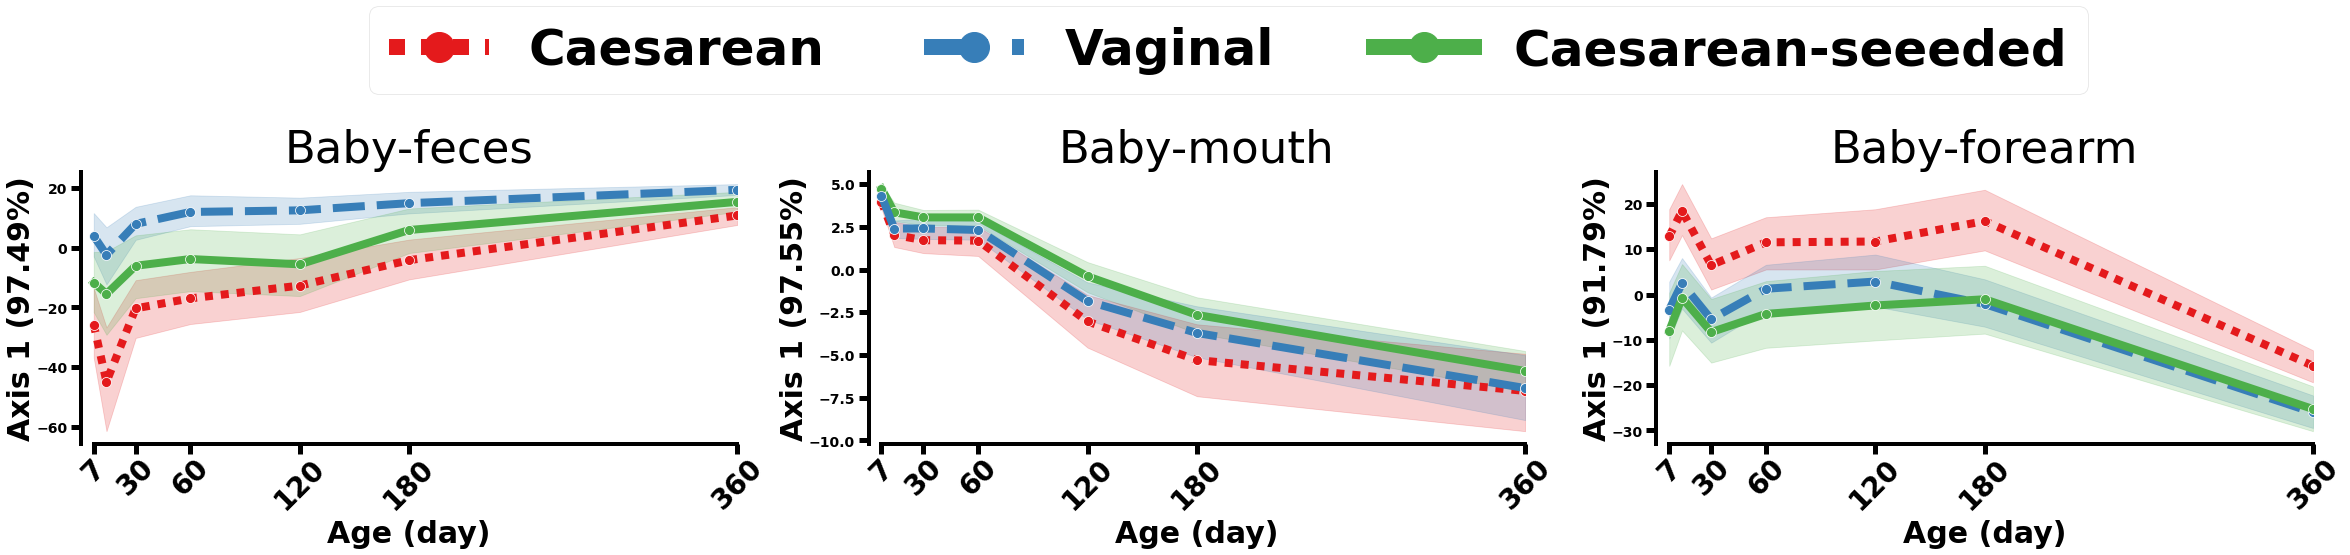

In [5]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

fig, axn = plt.subplots(1,3, figsize=(40,5))

color_by = 'birth_mode_ms'
time_ = 'date_sampling_category_days_continuous'
cmap_bm = {'CS':'#e41a1c',
           'CSseed':'#4daf4a',
           'Vag':'#377eb8'}

stypes = ['Baby-Feces','Baby-Mouth','Baby-Forearm']
t_range_ = '7-360'
pc_sum = {}
for stype_, ax, value_y in zip(stypes, axn.flatten(), ['PC1','PC1','PC1']):
    sub_trajs_plot = ctf_results[(stype_, t_range_)]['trajectory'].view(pd.DataFrame).copy()
    propexp = ctf_results[(stype_, t_range_)]['biplot'].view(OrdinationResults).proportion_explained
    PC_label = 'Axis 1' + ' (%.2f%%)'%(propexp[0] * 100)
    if  stype_ == 'skin':
        sub_trajs_plot = sub_trajs_plot[~sub_trajs_plot[time_].isin([120])]
    if  stype_ == 'oral':
        sub_trajs_plot = sub_trajs_plot[~sub_trajs_plot[time_].isin([90])]
    
    # get pc1 mean
    pc_sum[stype_] = sub_trajs_plot.groupby(["birth_mode_ms", time_])[value_y].mean()
       
    ax = temporal_plot(time_, value_y, sub_trajs_plot, ax,
                       stype_.capitalize(), 'Age (day)', PC_label, 45, 30, 30,
                       hue=color_by, style=color_by, min_x=7,
                       max_x = 360.0,
                       ci=68, cmap=cmap_bm)
    
    x_ticks = sorted(set(sub_trajs_plot.date_sampling_category_days_continuous))
    x_ticks.remove(14)
    ax.xaxis.set_ticks(x_ticks)
    ax.set_xlim(0, 360.0)
    
    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
          ax.spines[axis].set_linewidth(4)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
            
    ax.tick_params(axis='y', colors='black', width=5, length=10, left=True)
    ax.tick_params(axis='x', colors='black', width=5, length=10, bottom=True)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(28)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)
    
# generate legend from last iterations  
fix_labels = {'Vag':'Vaginal', 'CS':'Caesarean', 'CSseed':'Caesarean-seeeded'}
# generate legend from last iterations
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[1:], [fix_labels[l] for l in labels[1:]], loc=2,
                         bbox_to_anchor=(-2.0, 1.7),
                         prop={'size':50},
                         fancybox=True, framealpha=0.5, 
                         ncol=3, markerscale=3, facecolor="white")
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(16.0)
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

plt.savefig('../results/Figure-CTF.pdf',dpi=1000,
            bbox_inches='tight',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

plt.show()


In [9]:
pc_sum_df = pd.concat(pc_sum).reset_index()
pc_sum_df.rename({'level_0':'sample_type'}, axis = 1).to_csv('../results/CTF-PC1-sum.tsv', sep='\t')

In [16]:
%%capture

keep_ = {'Baby-Feces':['date_sampling_category_days_continuous',
                       'prep_name','birth_mode_ms','country',
                       'mother_prenatal_gbs','current_abx','subjectid_unique',
                       'current_solids','baby_sex','current_formula'
                       'current_breast_feeding','ever_abx',
                       'ever_breast_feeding','ever_formula'],
         'Baby-Mouth':['date_sampling_category_days_continuous',
                       'prep_name','birth_mode_ms','country',
                       'mother_prenatal_gbs','current_abx','subjectid_unique',
                       'current_solids','baby_sex','current_formula'
                       'current_breast_feeding', 'ever_abx',
                       'ever_breast_feeding','ever_formula'],
         'Baby-Forearm':['date_sampling_category_days_continuous',
                       'prep_name','birth_mode_ms','country',
                       'mother_prenatal_gbs','current_abx','subjectid_unique',
                       'current_solids','baby_sex','current_formula'
                       'current_breast_feeding','ever_abx',
                         'ever_breast_feeding','ever_formula']}
#stypes = ['fecal','skin','oral']
stypes = ['Baby-Feces','Baby-Mouth','Baby-Forearm']
t_range_ = '7-360'

es = {}
for stype_ in stypes:
    #sub_trajs_plot = sub_trajs[stype_].copy()
    sub_trajs_plot = ctf_results[(stype_, t_range_)]['trajectory'].view(pd.DataFrame).copy()
    sub_trajs_plot[sub_trajs_plot == 'nan'] = np.nan
    sub_trajs_plot.columns = [col_.replace('old_','')
                              for col_ in sub_trajs_plot.columns] 
    pc_cols = [col_ for col_ in sub_trajs_plot.columns
               if 'PC' in col_][:]
    metcols = [col_ for col_ in sub_trajs_plot.columns
               if 'PC' not in col_]
    metcols_ = list(set(keep_[stype_]) & set(metcols))
    sub_trajs_plot = sub_trajs_plot.loc[sub_trajs_plot[metcols_].dropna(0).index, :]
    es[stype_] = run_stepwise_anova(sub_trajs_plot[pc_cols],
                                    sub_trajs_plot[metcols_],
                                    metcols_)

In [17]:
rename_ = {'+ baby_sex':'Sex',
           '+ birth_mode_ms':'Birth mode',
           '+ current_abx':'ABX Current',
           '+ date_sampling_category_days_continuous':'Time (days)',
           '+ subjectid_unique':'Subject ID',
           '+ mother_prenatal_gbs':'Maternal Prenatal GBS',
           '+ country':'Country of Birth',
           '+ prep_name':'Sequencing Lane-Run',
           '+ current_solids':'Solid Food',
           '+ ever_breast_feeding':'Breastmilk dominant',
           '+ ever_formula':'Formula dominant',
           '+ ever_abx':'ABX Ever',
           '<All variables>':'All Others Aggergated'}

esdf = pd.concat(es).rename(rename_).fillna('-')
esdf = esdf.rename({'R2.adj':'Effect Size'}, axis=1)
esdf.index.names = ['body-site','metadata-column(s)']
esdf.to_csv('../results/Extended-Data-Table-3.tsv', sep='\t')
esdf

Effect Size Df      AIC        F  \
body-site    metadata-column(s)                                        
Baby-Feces   Birth mode                0.173595  2  948.512   14.864   
             Time (days)               0.099551  1  932.413   18.805   
             Country of Birth          0.021121  1  929.456  4.86064   
             Sex                       0.013851  1  927.777  3.56253   
             All Others Aggergated     0.005885  -        -        -   
Baby-Mouth   Time (days)               0.139350  1  756.996  20.9153   
             All Others Aggergated     0.022919  -        -        -   
Baby-Forearm Birth mode                0.090244  1  825.257  11.8124   
             Maternal Prenatal GBS     0.089378  1  814.858  12.7663   
             Time (days)               0.074449  1  805.361  11.6793   
             Country of Birth          0.042950  1  799.795  7.47628   
             All Others Aggergated     0.005414  -        -        -   

                                        Pr(>F)  
body-site    metadata-column(s)                 
Baby-Feces   Birth mode             0.00019996  
             Time (days)            0.00019996  
             Country of Birth        0.0205959  
             Sex                       0.04979  
             All Others Aggergated           -  
Baby-Mouth   Time (days)            0.00019996  
             All Others Aggergated           -  
Baby-Forearm Birth mode             0.00019996  
             Maternal Prenatal GBS  0.00019996  
             Time (days)            0.00059988  
             Country of Birth        0.0029994  
             All Others Aggergated           -

In [10]:
stypes = ['Baby-Feces','Baby-Mouth','Baby-Forearm']
t_range_ = '7-360'
dists = {}
for stype_ in stypes:
    #sub_trajs_plot = sub_trajs[stype_].copy()
    mf_ = ctf_results[(stype_, t_range_)]['metadata'].to_dataframe()
    dist_ = ctf_results[(stype_, t_range_)]['distance'].view(DistanceMatrix)
    dists[stype_] = [dist_, mf_]


In [19]:
permanova_res = {}
for type_, (dist_, mf_) in dists.items():
    mf_ = mf_.reindex(dist_.ids).copy()
    mf_['month'] = (mf_['date_sampling_category_days_continuous']//30) 
    for t_, mf_t in mf_.groupby('month'):
        # groups
        mf_t_1 = mf_t[mf_t.birth_mode_ms.isin(['CS','Vag'])]
        mf_t_2 = mf_t[mf_t.birth_mode_ms.isin(['CSseed','Vag'])]
        mf_t_3 = mf_t[mf_t.birth_mode_ms.isin(['CSseed','CS'])]    
        # permanovas
        if len(set(mf_t_1['birth_mode_ms'])) > 1:
            pone = permanova(dist_.filter(mf_t_1.index),
                          mf_t_1['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CS', 'Vag')] = pd.DataFrame(pone).T
        if len(set(mf_t_2['birth_mode_ms'])) > 1:
            ptwo = permanova(dist_.filter(mf_t_2.index),
                          mf_t_2['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CSseed', 'Vag')] = pd.DataFrame(ptwo).T
        if len(set(mf_t_3['birth_mode_ms'])) > 1:
            pthree = permanova(dist_.filter(mf_t_3.index),
                            mf_t_3['birth_mode_ms'],
                          permutations=1000)
            permanova_res[(type_, t_, 'CSseed', 'CS')] = pd.DataFrame(pthree).T

permanova_res = pd.concat(permanova_res)
permanova_res = permanova_res.reset_index()
permanova_res = permanova_res.rename({'level_0':'sample_type',
                                     'level_1':'timepoint',
                                     'level_2':'compare_1',
                                     'level_3':'compare_2',
                                     'level_4':'test_type'},
                                     axis=1)
permanova_res['fdr_bh'] = multipletests(permanova_res['p-value'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
permanova_res.to_csv('../results/CTF-PERMANOVA.tsv', sep='\t')
permanova_res.head(5)


,sample_type,timepoint,compare_1,compare_2,test_type,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations,fdr_bh
0,Baby-Feces,0.0,CS,Vag,PERMANOVA results,PERMANOVA,pseudo-F,63,2,9.51814,0.003996,1000,0.0539461
1,Baby-Feces,0.0,CSseed,Vag,PERMANOVA results,PERMANOVA,pseudo-F,63,2,1.90108,0.172827,1000,0.373307
2,Baby-Feces,0.0,CSseed,CS,PERMANOVA results,PERMANOVA,pseudo-F,50,2,2.11486,0.160839,1000,0.373307
3,Baby-Feces,1.0,CS,Vag,PERMANOVA results,PERMANOVA,pseudo-F,53,2,6.65731,0.002997,1000,0.0539461
4,Baby-Feces,1.0,CSseed,Vag,PERMANOVA results,PERMANOVA,pseudo-F,45,2,1.47561,0.234765,1000,0.452762


(18, 12)
(18, 12)
(18, 12)


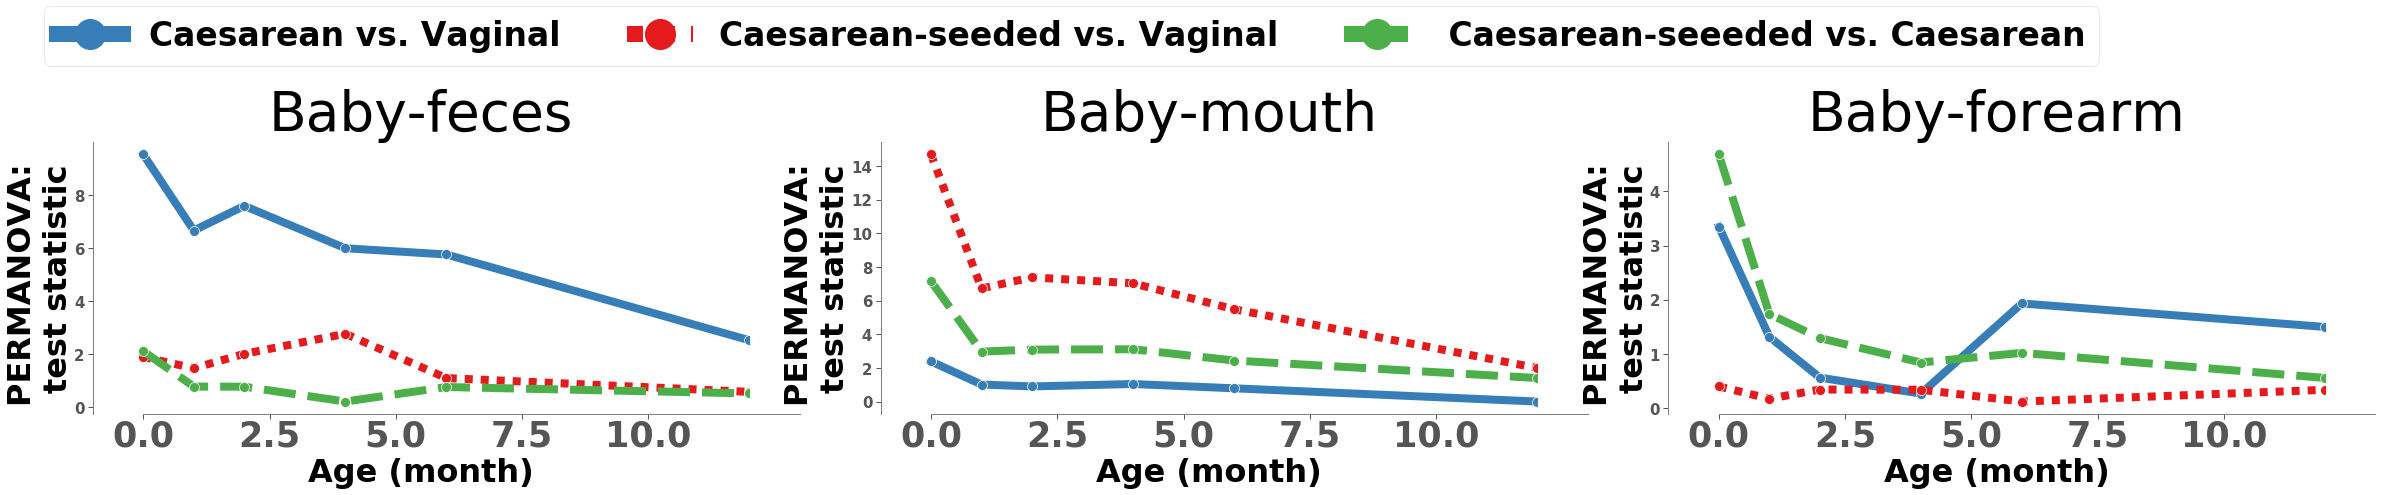

(18, 12)
(18, 12)
(18, 12)


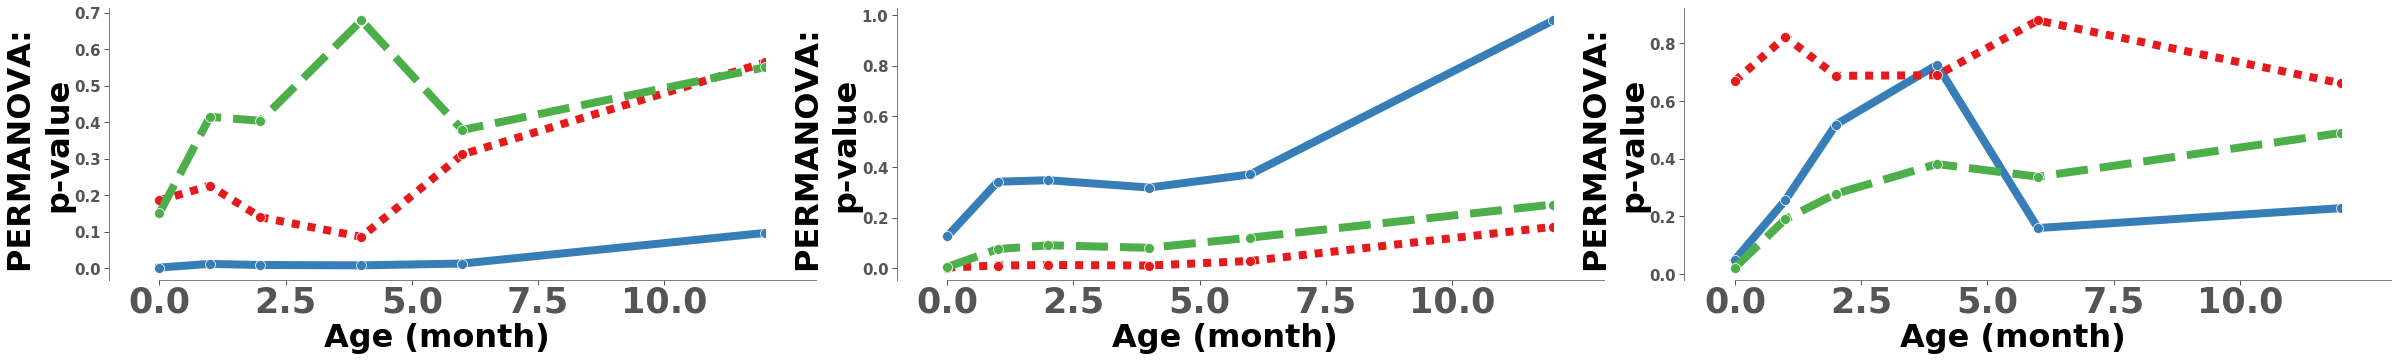

In [20]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 8, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 35 
plt.rcParams['ytick.labelsize'] = 15

labels_map = {'test statistic':'a','p-value':'b'}

for value_ in ['test statistic','p-value']:

    fig, axn = plt.subplots(1,3, figsize=(40,5))

    color_by = 'compare'
    time_ = 'timepoint'
    cmap_bm = {'CS vs. Vag':'#377eb8',
               'CSseed vs. CS':'#4daf4a',
               'CSseed vs. Vag':'#e41a1c'}

    stypes = ['Baby-Feces','Baby-Mouth','Baby-Forearm']
    for stype_, ax, value_y in zip(stypes,
                                   axn.flatten(),
                                   [value_, value_, value_]):

        sub_trajs_plot = permanova_res[permanova_res.sample_type.isin([stype_])].copy()
        print(sub_trajs_plot.shape)
        sub_trajs_plot = sub_trajs_plot[sub_trajs_plot[time_] < 360.0]
        sub_trajs_plot[time_] = sub_trajs_plot[time_].astype(int)
        sub_trajs_plot[value_] = sub_trajs_plot[value_].astype(float)
        sub_trajs_plot['compare'] = sub_trajs_plot['compare_1'] + \
                                    ' vs. ' + sub_trajs_plot['compare_2']
        PC_label = 'PERMANOVA: \n' + value_
        
        if value_ != 'p-value':
            title_ = stype_.capitalize()
        else:
            title_ = ''

        ax = temporal_plot(time_, value_y, sub_trajs_plot, ax, title_ ,
                           'Age (month)', PC_label, 55, 32, 32,
                           hue=color_by, style=color_by, min_x=0,
                           max_x = 13.0, err_style='bars',
                           ci=68, cmap=cmap_bm,
                           style_order_ = ['CS vs. Vag',
                                           'CSseed vs. CS',
                                           'CSseed vs. Vag'])
        
        ax.set_xlim(-1.0, 12.0)

    # generate legend from last iterations    
    fix_labels = {'CS vs. Vag':'Caesarean vs. Vaginal',
                  'CSseed vs. CS':' Caesarean-seeeded vs. Caesarean',
                  'CSseed vs. Vag':'Caesarean-seeded vs. Vaginal'}
    if value_ != 'p-value':
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[1:],
                           [fix_labels[l] for l in labels[1:]],
                           loc=2, 
                           bbox_to_anchor=(-2.5, 1.56),
                           prop={'size':33},
                           fancybox=True, framealpha=0.5, 
                           ncol=3, markerscale=3, facecolor="white")
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(16.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(16.0)

    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)

    
    plt.savefig('../results/Extended-Data-Figure-2-%s.pdf' % labels_map[value_],
                dpi=1000, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    

    plt.show()